In [18]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.base import BaseEstimator

from modules import UNet_conditional, EMA
from ddpm_conditional import Diffusion
from utils import save_images

from utils import get_data

from modules import Down, Up

In [ ]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb
    

def AutoEncoder(BaseEstimator):
    def __init__(self, shape, latent_dim):
        self.shape = shape
        self.latent_dim = latent_dim
        self._build_network()
        
    def _build_network(self):
        initial_dim = shape[1] * shape[2] * shape[3]
        latent_dim_per_res = [initial_dim / 4 ** i for i in range(1, 4)] 
        latent_dim_per_res = [l for l in latent_dim_per_res if l == int(l)]
        n_down_blocks = len(latent_dim_per_res)
        
        Encoder = torch.nn.Sequential([Down()])
            

In [2]:
def _flatten(images: torch.Tensor):
    return images.flatten(start_dim=1)


def _unflatten(images, shape=None):
    if shape is None:
        shape = (3, 48, 32)
        
    if not isinstance(images, torch.Tensor):
        images = torch.Tensor(images)
    
    unf = torch.nn.Unflatten(1, shape)
    return unf(images)

In [3]:
class Args:
    def __init__(self, data_path, batch_size):
        self.dataset_path = data_path
        self.batch_size = batch_size
        
        
def preprocess_images(images):
    if len(images.shape) > 2:
        images = _flatten(images)
    return images


def calculate_score(true, pred, scoring_func):
    true = preprocess_images(true)
    pred = preprocess_images(pred)
    return np.array([scoring_func(t, p) for t, p in zip(true, pred)])
        
    
def squared_error(true, pred):
    return calculate_score(true, pred, mean_squared_error)


def absolute_error(true, pred):
    return calculate_score(true, pred, mean_absolute_error)

In [16]:
def pca_compression(real, gen, n_components=20):
    pca = PCA(n_components=n_components)
    pca.fit(real)
    real_bis = pca.inverse_transform(pca.transform(real))
    gen_bis = pca.inverse_transform(pca.transform(gen))
    return real_bis, gen_bis


def get_compression_1d(real_images, gen_images, compression_func, *args, **kwargs):
    flat_real = _flatten(real_images)
    flat_gen = _flatten(gen_images)
    
    real_bis, gen_bis = compression_func(flat_real, flat_gen, *args, **kwargs)
    
    shape = real_images.shape[1:]
    return _unflatten(real_bis, shape=shape), _unflatten(gen_bis, shape=shape)


def get_pca_compression(real_images, gen_images, n_components=20):
    return get_compression_1d(real_images, gen_images, compression_func=pca_compression, n_components=n_components)


def get_ae_compression(real_images, gen_images, latent_dim=100, epochs=30):
    ae = AutoEncoder(shape=real_images.shape[1:], latent_dim=latent_dim)
    ae.fit(real_images, epochs=epochs)
    
    real_bis = ae.predict(real_images)
    gen_bis = ae.predict(gen_bis)
    return real_bis, gen_bis
    

In [5]:
data_path = 'data/margonem'
args = Args(**{'data_path': data_path, 'batch_size': 32})

In [6]:
images = []
labels = []
for x, y in get_data(args):
    images.append(x)
    labels.append(y)
images = torch.cat(images)
labels = torch.cat(labels)

In [7]:
# num_classes = 67
# device = "cuda"
# image_size = (48, 32)

# # initialize the model and diffusion class
# model = UNet_conditional(num_classes=num_classes).to(device)
# diffusion = Diffusion(img_size=image_size, device=device)

# # load saved model weights
# weights_path = 'models/DDPM_conditional/ema_ckpt.pt'
# # model = 
# model.load_state_dict(torch.load(weights_path))

# # images_per_class = 32
# # n_to_plot = num_classes * images_per_class

# viz_noise = torch.randn((len(flat_images), 3, image_size[0], image_size[1])).to(device)
# # viz_labels = torch.arange(n_to_plot // images_per_class).long().repeat(images_per_class).to(device)
# sampled_images = diffusion.sample(model, n=len(flat_images), labels=labels.to(device), noise=viz_noise, batch=32)

In [8]:
# for i, img in enumerate(sampled_images.to('cpu')):
#     save_images(img, f'generated/{i}.png', nrow=1)

In [9]:
data_path = 'generated'
args = Args(**{'data_path': data_path, 'batch_size': 32})

In [10]:
gen_images = []
for x, _ in get_data(args):
    gen_images.append(x)
gen_images = torch.cat(gen_images)

In [14]:
real_bis, gen_bis = get_pca_compression(real_images=images, gen_images=gen_images, n_components=1000)
r_rerrors_real = absolute_error(images, real_bis)
r_errors_gen = absolute_error(gen_images, gen_bis)

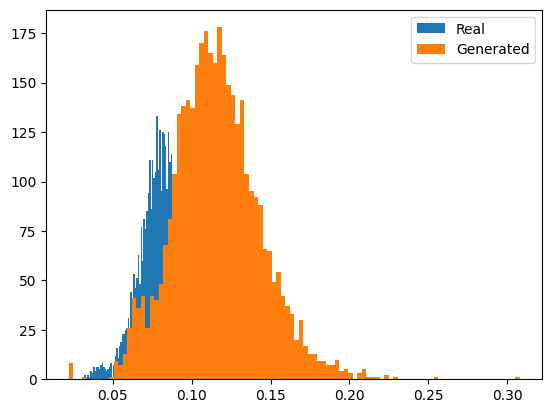

In [15]:
plt.hist(r_rerrors_real, bins=100, label='Real')
plt.hist(r_errors_gen, bins=100, label='Generated')
plt.legend()
plt.show()

In [13]:
idx = np.random.choice(len(real_bis), size=4, replace=False)
viz = torch.cat([images[idx], real_bis[idx], gen_images[idx], gen_bis[idx]])
save_images(viz, 'compression_viz.png', nrow=4)